In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [3]:
# Closed Loop dataset
exp_ids=['2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq',
         '2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq',
#          '2018_05_22_21_46_10_Closed loop with atoms',
#          '2018_05_22_22_18_16_Closed loop with atoms',
#          '2018_05_22_22_46_40_Closed loop with atoms',
#          '2018_05_22_23_11_36_Closed loop with atoms',
#          '2018_05_22_23_32_23_Closed loop with atoms',
#          '2018_05_22_23_53_45_Closed loop with atoms',
#          '2018_05_23_00_29_09_Closed loop with atoms',
#          '2018_05_23_00_44_43_Closed loop with atoms',
#          '2018_05_23_00_59_19_Closed loop with atoms',
         '2018_05_23_01_17_11_Closed loop with atoms',
         '2018_05_23_01_36_47_Closed loop with atoms',
#        2018_05_23_01_57_43_Closed loop without atoms',
         #'2018_05_23_08_45_38_Closed loop with atoms' ,
         '2018_05_23_09_57_07_Closed loop with atoms',
         '2018_05_23_10_33_33_Closed loop with atoms',
         '2018_05_23_11_10_20_Closed loop with atoms',
        # '2018_05_23_11_47_07_Closed loop with atoms', this one looks okay, but wont fit for some reason, took it out for now
         '2018_05_23_13_54_23_Closed loop with atoms',
         '2018_05_23_14_17_56_Closed loop with atoms',
         '2018_05_23_14_40_03_Closed loop with atoms',
         '2018_05_23_15_06_01_Closed loop with atoms',
         '2018_05_23_20_45_08_Closed loop with atoms',
         '2018_05_23_21_07_39_Closed loop with atoms',
         '2018_05_24_01_13_31_Closed loop with atoms, extended BA',
         '2018_05_24_01_38_13_Closed loop with atoms, FORT lowered',
         #'2018_05_24_11_21_39_Closed loop with atoms',
         '2018_05_24_11_39_12_Closed loop with atoms',
         '2018_05_24_11_56_45_Closed loop with atoms',
         '2018_05_24_12_12_20_Closed loop with atoms',
         '2018_05_24_12_27_22_Closed loop with atoms',
         '2018_05_24_12_41_35_Closed loop with atoms',
         '2018_05_24_12_56_48_Closed loop with atoms',
         '2018_05_24_13_09_08_Closed loop with atoms',
         '2018_05_24_13_22_39_Closed loop with atoms',
         '2018_06_04_17_42_01_Ramsey closed loop',
         '2018_06_04_17_59_41_Ramsey closed loop',
         '2018_06_04_19_36_47_Ramsey closed loop'
        ]


In [4]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_17_11_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_36_47_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_09_57_07_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_10_33_33_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :

# Experiment-wise analysis

2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq
0


<IPython.core.display.Javascript object>


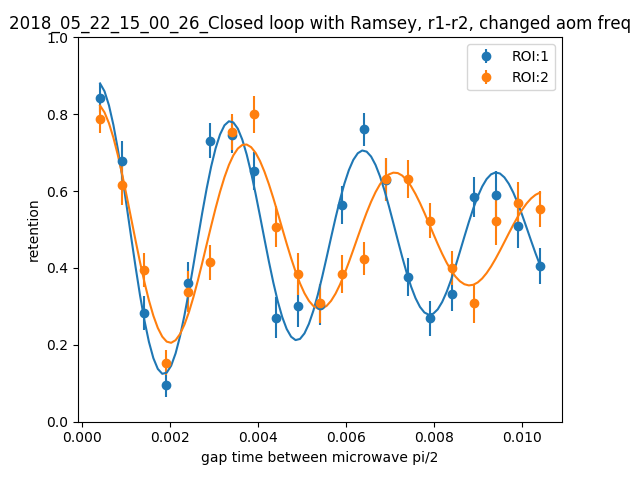

[0.017, 0.35286934043409807, 300, 1.5707963267948966, 0.48998780242304479]
tau 1  is  0.0105174054982  with 1 std of   0.00233432647605
amplitude 1  is  0.420814508975  with 1 std of   0.0398497922542
frequency 1  is  330.77706605  with 1 std of   3.49780488735
phase 1  is  0.83090511648  with 1 std of   0.107550332808
offset 1  is  0.476631705785  with 1 std of   0.0114888778812
[0.017, 0.30447330447330445, 300, 1.5707963267948966, 0.49552669552669559]
tau 2  is  0.00903369828425  with 1 std of   0.00251636977476
amplitude 2  is  0.353018989722  with 1 std of   0.0476345769782
frequency 2  is  294.031987058  with 1 std of   5.66808613638
phase 2  is  0.963829468613  with 1 std of   0.161017913199
offset 2  is  0.487624682905  with 1 std of   0.013679427706
2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq
1


<IPython.core.display.Javascript object>


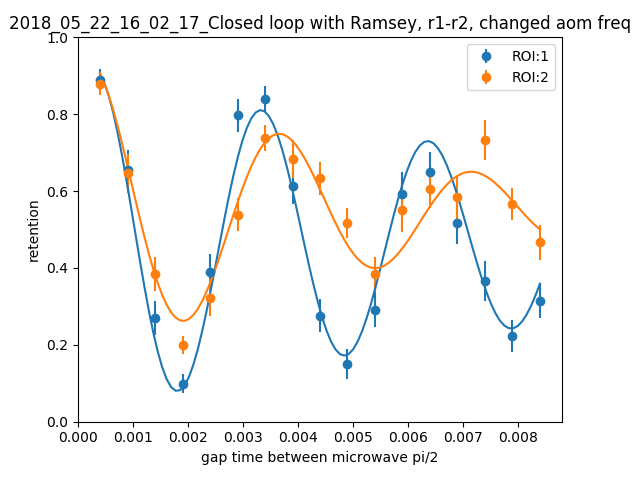

[0.017, 0.42209385360943763, 300, 1.5707963267948966, 0.46679503527945121]
tau 1  is  0.0112677604316  with 1 std of   0.00333489384083
amplitude 1  is  0.45824527445  with 1 std of   0.0479697058971
frequency 1  is  329.240589137  with 1 std of   4.5429175581
phase 1  is  0.937891035103  with 1 std of   0.120012068927
offset 1  is  0.469906867635  with 1 std of   0.0146433997713
[0.017, 0.32391839918358722, 300, 1.5707963267948966, 0.55486947960429156]
tau 2  is  0.00526504062209  with 1 std of   0.001282335309
amplitude 2  is  0.409772400756  with 1 std of   0.0581062340334
frequency 2  is  286.369292586  with 1 std of   7.69078725775
phase 2  is  1.17014238218  with 1 std of   0.161321709061
offset 2  is  0.545604346879  with 1 std of   0.0141988500384
2018_05_23_01_17_11_Closed loop with atoms
2


<IPython.core.display.Javascript object>


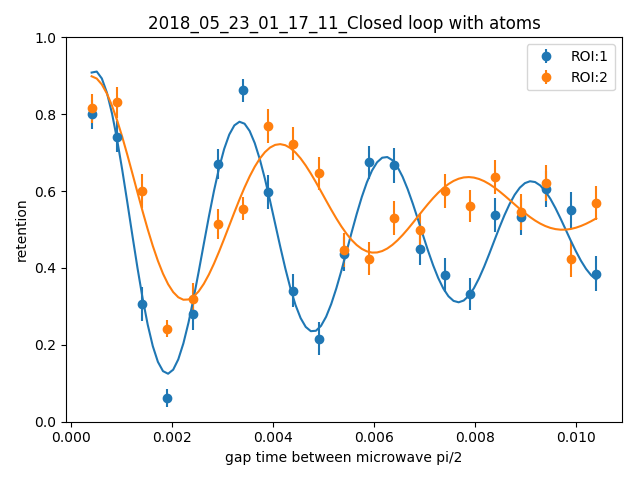

[0.017, 0.36508769455305096, 300, 1.5707963267948966, 0.49661443310652348]
tau 1  is  0.00786066498654  with 1 std of   0.00148742524423
amplitude 1  is  0.456704648885  with 1 std of   0.0446666886086
frequency 1  is  347.056804887  with 1 std of   4.33669715072
phase 1  is  0.503097013264  with 1 std of   0.118536365326
offset 1  is  0.482590063199  with 1 std of   0.0123567258024
[0.017, 0.26543456543456556, 300, 1.5707963267948966, 0.56533466533466525]
tau 2  is  0.00516950024115  with 1 std of   0.00140168161606
amplitude 2  is  0.372311405963  with 1 std of   0.0621344782065
frequency 2  is  267.575065735  with 1 std of   9.76703297649
phase 2  is  0.800341657398  with 1 std of   0.221125945042
offset 2  is  0.555718928405  with 1 std of   0.0155861231443
2018_05_23_01_36_47_Closed loop with atoms
3


<IPython.core.display.Javascript object>


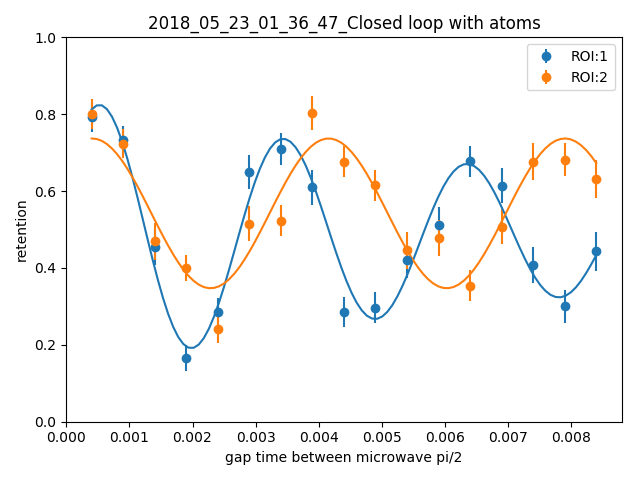

[0.017, 0.30063191687195512, 300, 1.5707963267948966, 0.49157587533583713]
tau 1  is  0.00970461361276  with 1 std of   0.00301559186349
amplitude 1  is  0.359475698095  with 1 std of   0.0432442894691
frequency 1  is  343.208889811  with 1 std of   5.48925460281
phase 1  is  0.395459534427  with 1 std of   0.142724366913
offset 1  is  0.484108207394  with 1 std of   0.0131659556894
[0.017, 0.24163617600150089, 300, 1.5707963267948966, 0.56139412702880209]
tau 2  is  -170243.072221  with 1 std of   547002474993.0
amplitude 2  is  0.194810586717  with 1 std of   0.0366056948124
frequency 2  is  266.953573929  with 1 std of   9.51790860104
phase 2  is  0.88169074764  with 1 std of   0.308716946077
offset 2  is  0.542062115808  with 1 std of   0.0181766025106
2018_05_23_09_57_07_Closed loop with atoms
4


<IPython.core.display.Javascript object>


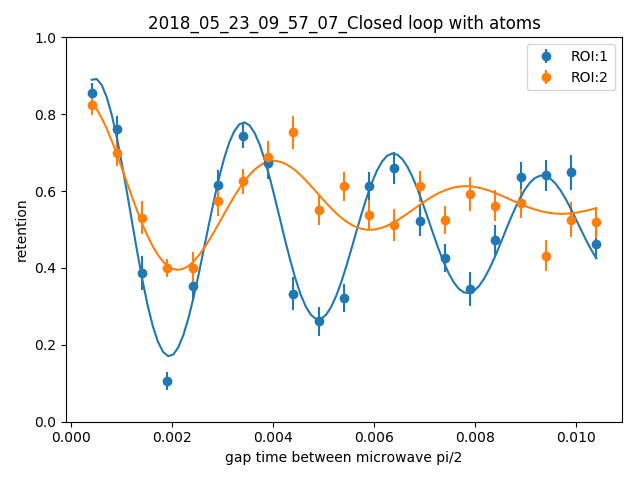

[0.017, 0.33847573926464281, 300, 1.5707963267948966, 0.51622511543621186]
tau 1  is  0.00860214220876  with 1 std of   0.00165820089534
amplitude 1  is  0.414586520044  with 1 std of   0.0386691746972
frequency 1  is  338.319331047  with 1 std of   3.86140863116
phase 1  is  0.536306172072  with 1 std of   0.110973380061
offset 1  is  0.500608590502  with 1 std of   0.0108731976054
[0.017, 0.25142563198118739, 300, 1.5707963267948966, 0.57357436801881256]
tau 2  is  0.00415249639618  with 1 std of   0.00120625937746
amplitude 2  is  0.291759177496  with 1 std of   0.0572433769313
frequency 2  is  262.911453954  with 1 std of   12.8883327675
phase 2  is  1.08392643787  with 1 std of   0.251291117591
offset 2  is  0.568774860419  with 1 std of   0.0125703558301
2018_05_23_10_33_33_Closed loop with atoms
5


<IPython.core.display.Javascript object>


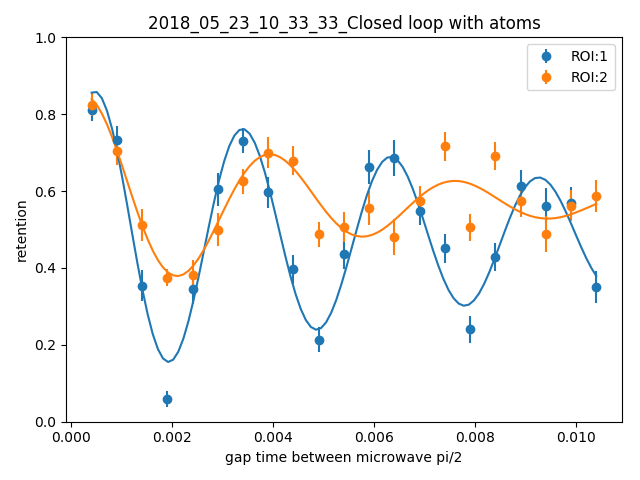

[0.017, 0.31692219017429529, 300, 1.5707963267948966, 0.49504362179151667]
tau 1  is  0.0098291485175  with 1 std of   0.00224416517435
amplitude 1  is  0.3966992494  with 1 std of   0.0405292441487
frequency 1  is  340.992206742  with 1 std of   4.03269301844
phase 1  is  0.539792774896  with 1 std of   0.120563360698
offset 1  is  0.481072746082  with 1 std of   0.0117458999295
[0.017, 0.25191798941798937, 300, 1.5707963267948966, 0.57308201058201058]
tau 2  is  0.00469623487196  with 1 std of   0.00137309067766
amplitude 2  is  0.29752972279  with 1 std of   0.0558662137081
frequency 2  is  272.477992974  with 1 std of   11.1860853453
phase 2  is  1.00388708289  with 1 std of   0.238302822864
offset 2  is  0.567992744987  with 1 std of   0.0130811758837
2018_05_23_11_10_20_Closed loop with atoms
6


<IPython.core.display.Javascript object>


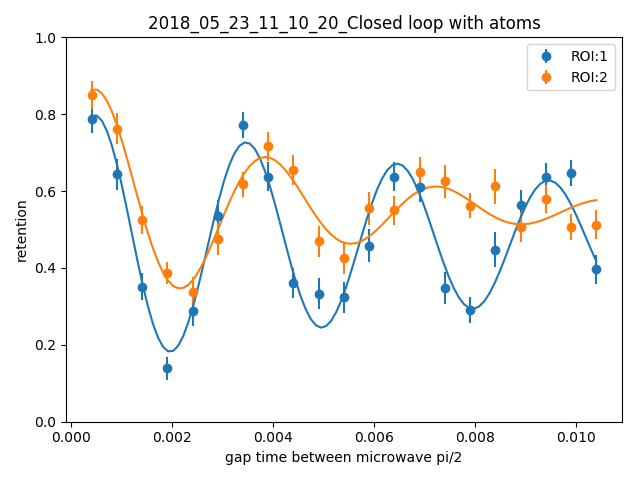

[0.017, 0.30220759861138352, 300, 1.5707963267948966, 0.48602769550626351]
tau 1  is  0.0122494368982  with 1 std of   0.00359042814666
amplitude 1  is  0.33949745756  with 1 std of   0.0378401003117
frequency 1  is  333.536365781  with 1 std of   3.99634488144
phase 1  is  0.571882351215  with 1 std of   0.128615196698
offset 1  is  0.471120457169  with 1 std of   0.011386856866
[0.017, 0.2842886537330982, 300, 1.5707963267948966, 0.56571134626690178]
tau 2  is  0.0040625280428  with 1 std of   0.000797326807222
amplitude 2  is  0.353069596558  with 1 std of   0.0451746216143
frequency 2  is  295.877829887  with 1 std of   9.16172560759
phase 2  is  0.581055704921  with 1 std of   0.178378110349
offset 2  is  0.552680797779  with 1 std of   0.0104065101819
2018_05_23_13_54_23_Closed loop with atoms
7


<IPython.core.display.Javascript object>


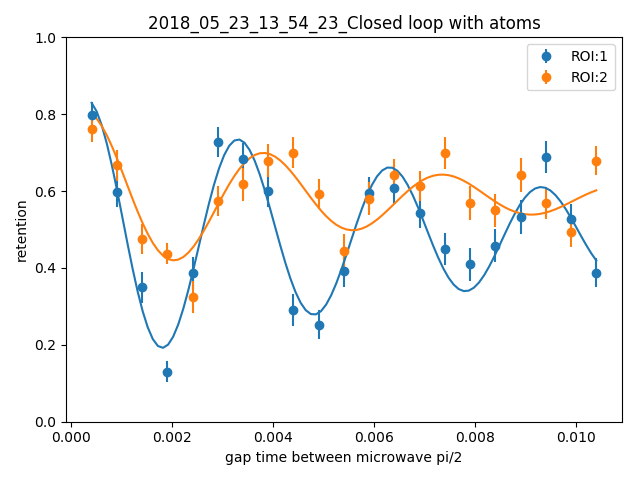

[0.017, 0.30209667673492857, 300, 1.5707963267948966, 0.49577566369060333]
tau 1  is  0.00865596889554  with 1 std of   0.0020350780386
amplitude 1  is  0.363323516642  with 1 std of   0.0416520655215
frequency 1  is  333.07407268  with 1 std of   4.56273100669
phase 1  is  0.889941704394  with 1 std of   0.130720070293
offset 1  is  0.486772135611  with 1 std of   0.0114498389654
[0.017, 0.17629335684891234, 300, 1.5707963267948966, 0.58620664315108761]
tau 2  is  0.00538399853547  with 1 std of   0.0022640393015
amplitude 2  is  0.238328829409  with 1 std of   0.0616462577679
frequency 2  is  282.284149169  with 1 std of   13.8107572727
phase 2  is  1.00731961904  with 1 std of   0.318125045555
offset 2  is  0.582346314344  with 1 std of   0.0151327482157
2018_05_23_14_17_56_Closed loop with atoms
8


<IPython.core.display.Javascript object>


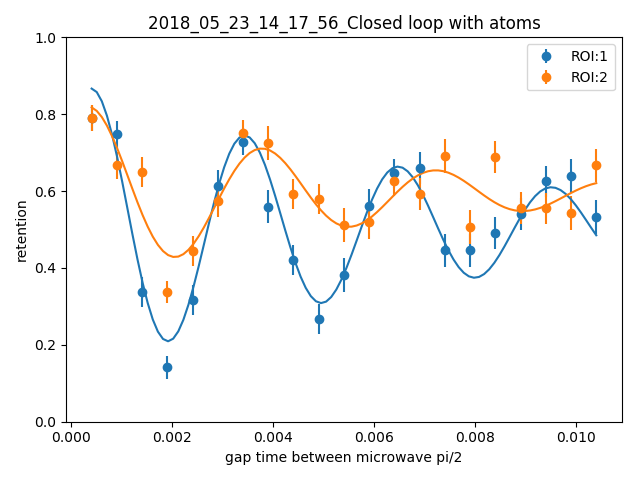

[0.017, 0.27213247150526798, 300, 1.5707963267948966, 0.51834371897092246]
tau 1  is  0.00740031416538  with 1 std of   0.0015827625738
amplitude 1  is  0.382893906036  with 1 std of   0.0430151779026
frequency 1  is  329.068266175  with 1 std of   4.95857953493
phase 1  is  0.694284153818  with 1 std of   0.134914454258
offset 1  is  0.504343108004  with 1 std of   0.0116186270919
[0.017, 0.19173280423280425, 300, 1.5707963267948966, 0.59839065255731916]
tau 2  is  0.0052783165593  with 1 std of   0.00210470232064
amplitude 2  is  0.243220646099  with 1 std of   0.0597577782665
frequency 2  is  290.204379664  with 1 std of   13.9275996272
phase 2  is  0.869935520794  with 1 std of   0.316879567457
offset 2  is  0.592426560154  with 1 std of   0.0149405956767
2018_05_23_14_40_03_Closed loop with atoms
9


<IPython.core.display.Javascript object>


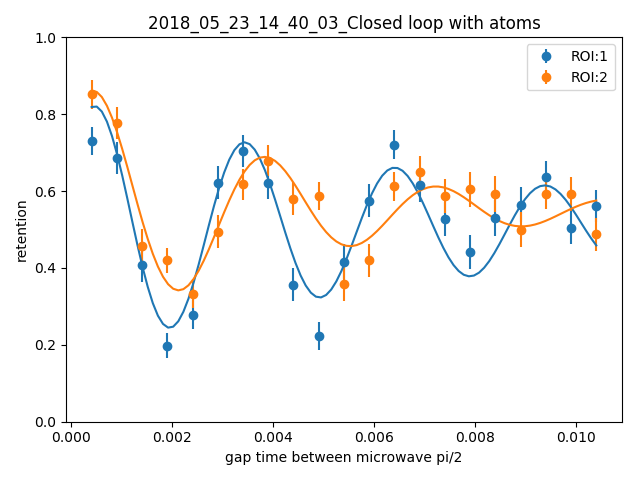

[0.017, 0.20998440669464924, 300, 1.5707963267948966, 0.52001559330535074]
tau 1  is  0.00834300261519  with 1 std of   0.00265285320916
amplitude 1  is  0.332353779823  with 1 std of   0.0519273413747
frequency 1  is  336.290795688  with 1 std of   6.53489046676
phase 1  is  0.545790783423  with 1 std of   0.186233610526
offset 1  is  0.507079719426  with 1 std of   0.014492039066
[0.017, 0.29016754850088178, 300, 1.5707963267948966, 0.56168430335097008]
tau 2  is  0.00422201564874  with 1 std of   0.00109653173853
amplitude 2  is  0.346996426307  with 1 std of   0.0582971455363
frequency 2  is  294.376805201  with 1 std of   11.6745235192
phase 2  is  0.656643436459  with 1 std of   0.233123700785
offset 2  is  0.549813374663  with 1 std of   0.0136789531255
2018_05_23_15_06_01_Closed loop with atoms
10


<IPython.core.display.Javascript object>


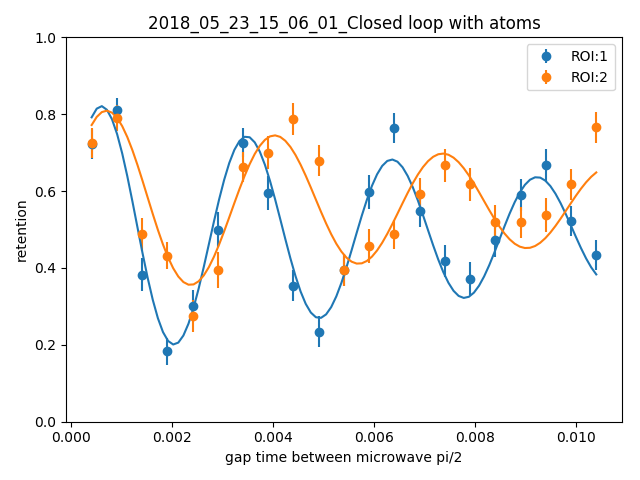

[0.017, 0.30573741159711898, 300, 1.5707963267948966, 0.50426258840288107]
tau 1  is  0.0105887243747  with 1 std of   0.00263219682024
amplitude 1  is  0.350596624945  with 1 std of   0.0374804406677
frequency 1  is  347.452987594  with 1 std of   4.04110583077
phase 1  is  0.234405129575  with 1 std of   0.122364162882
offset 1  is  0.489859747999  with 1 std of   0.0108579501373
[0.017, 0.21360229276895948, 300, 1.5707963267948966, 0.57652116402116393]
tau 2  is  0.0108982175179  with 1 std of   0.00570291722329
amplitude 2  is  0.260333814933  with 1 std of   0.0574080463928
frequency 2  is  300.212617841  with 1 std of   8.26429056729
phase 2  is  0.212474510474  with 1 std of   0.251835472128
offset 2  is  0.565257756825  with 1 std of   0.0167667351785
2018_05_23_20_45_08_Closed loop with atoms
11


<IPython.core.display.Javascript object>


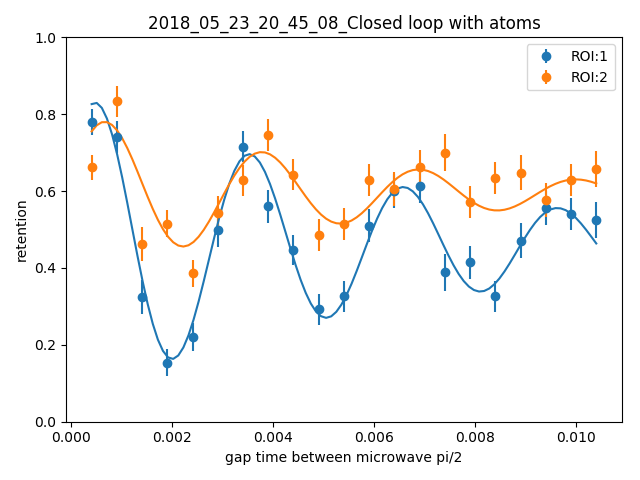

[0.017, 0.30330451891608667, 300, 1.5707963267948966, 0.4765119948453812]
tau 1  is  0.00680853667074  with 1 std of   0.00112058000496
amplitude 1  is  0.398146877985  with 1 std of   0.0358990484747
frequency 1  is  327.60945608  with 1 std of   4.23193316598
phase 1  is  0.533390126464  with 1 std of   0.110826818917
offset 1  is  0.459417819147  with 1 std of   0.00955966553408
[0.017, 0.227118309814487, 300, 1.5707963267948966, 0.60621502351884637]
tau 2  is  0.00560039835378  with 1 std of   0.00284164526699
amplitude 2  is  0.208397780348  with 1 std of   0.0654421824983
frequency 2  is  321.2199311  with 1 std of   16.1610765761
phase 2  is  0.160040191454  with 1 std of   0.373818527063
offset 2  is  0.595587348808  with 1 std of   0.0158576879057
2018_05_23_21_07_39_Closed loop with atoms
12


<IPython.core.display.Javascript object>


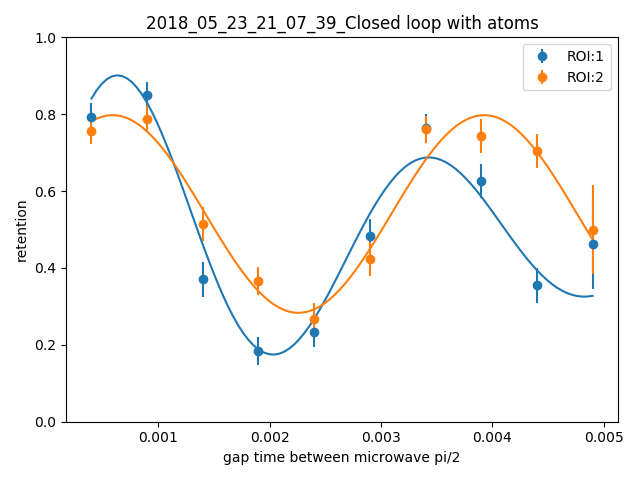

[0.017, 0.33709768217451641, 300, 1.5707963267948966, 0.51221738631863423]
tau 1  is  0.00401495938502  with 1 std of   0.00184327653282
amplitude 1  is  0.501691243092  with 1 std of   0.123433585489
frequency 1  is  357.834406086  with 1 std of   21.0985754332
phase 1  is  0.0354461922341  with 1 std of   0.291671013961
offset 1  is  0.47531187568  with 1 std of   0.0320841259434
[0.017, 0.20631790744466805, 300, 1.5707963267948966, 0.58241448692152908]
tau 2  is  -32584.9218208  with 1 std of   84398040424.4
amplitude 2  is  0.257178794931  with 1 std of   0.0564621012532
frequency 2  is  299.624963695  with 1 std of   11.6880926283
phase 2  is  0.460685297558  with 1 std of   0.239277531526
offset 2  is  0.540426131108  with 1 std of   0.0184766477424
2018_05_24_01_13_31_Closed loop with atoms, extended BA
13


<IPython.core.display.Javascript object>


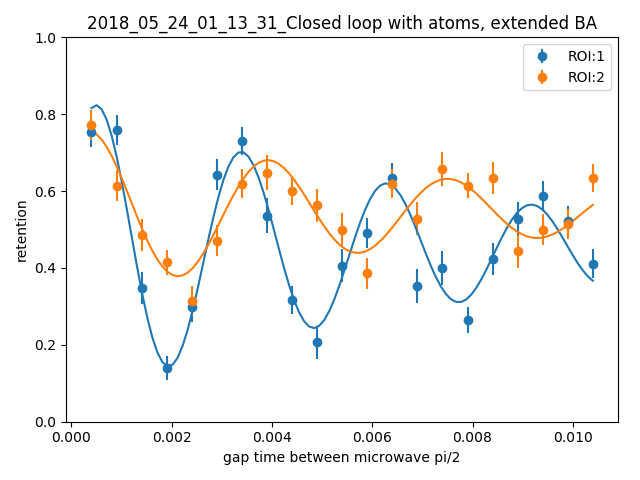

[0.017, 0.29481695491492016, 300, 1.5707963267948966, 0.46421918966339309]
tau 1  is  0.00735178854512  with 1 std of   0.00170950668926
amplitude 1  is  0.399870569891  with 1 std of   0.0496254615136
frequency 1  is  345.715748241  with 1 std of   5.6327513317
phase 1  is  0.438360553662  with 1 std of   0.150418216737
offset 1  is  0.450336030375  with 1 std of   0.0134466771226
[0.017, 0.22225735364568366, 300, 1.5707963267948966, 0.5491712177828878]
tau 2  is  0.00799163223959  with 1 std of   0.00337576422894
amplitude 2  is  0.219606979881  with 1 std of   0.0466438879652
frequency 2  is  279.13729635  with 1 std of   9.02536732528
phase 2  is  0.913208448793  with 1 std of   0.253266300842
offset 2  is  0.546335705853  with 1 std of   0.0129878038545
2018_05_24_01_38_13_Closed loop with atoms, FORT lowered
14


<IPython.core.display.Javascript object>


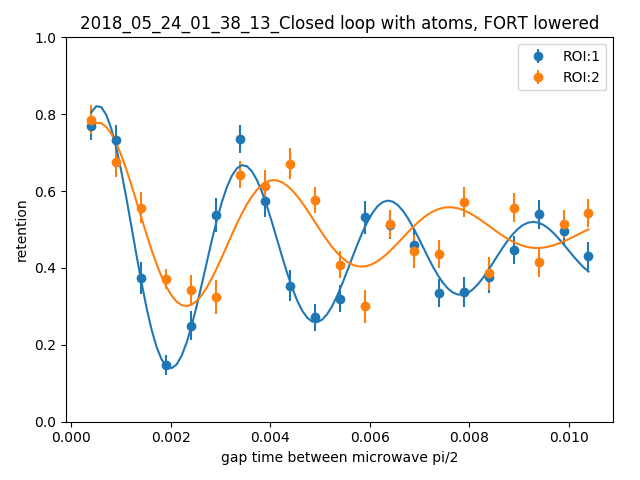

[0.017, 0.31603417476097917, 300, 1.5707963267948966, 0.45408076776775641]
tau 1  is  0.0056950405588  with 1 std of   0.000734384409205
amplitude 1  is  0.424550258283  with 1 std of   0.0326978315668
frequency 1  is  342.824772127  with 1 std of   3.97351313205
phase 1  is  0.332207323904  with 1 std of   0.094354368687
offset 1  is  0.437028823828  with 1 std of   0.00813749816978
[0.017, 0.27851873143623651, 300, 1.5707963267948966, 0.50719555427804919]
tau 2  is  0.00469391654217  with 1 std of   0.00169618938875
amplitude 2  is  0.320150903272  with 1 std of   0.0725800871085
frequency 2  is  283.419208309  with 1 std of   13.7835827784
phase 2  is  0.482282501313  with 1 std of   0.297358878091
offset 2  is  0.495137133584  with 1 std of   0.0174001142463
2018_05_24_11_39_12_Closed loop with atoms
15


<IPython.core.display.Javascript object>


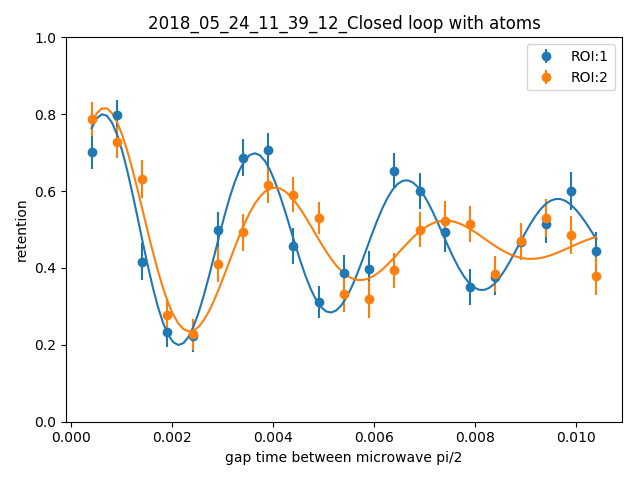

[0.017, 0.30605599761563279, 300, 1.5707963267948966, 0.49104545165972951]
tau 1  is  0.00809409220469  with 1 std of   0.00162798234028
amplitude 1  is  0.355173432716  with 1 std of   0.0361227045685
frequency 1  is  332.901110225  with 1 std of   4.17125148468
phase 1  is  0.203849303359  with 1 std of   0.11685173585
offset 1  is  0.472099351279  with 1 std of   0.00978163849352
[0.017, 0.30597180597180584, 300, 1.5707963267948966, 0.481906981906982]
tau 2  is  0.00383376460852  with 1 std of   0.000855220948909
amplitude 2  is  0.423735882218  with 1 std of   0.0643812827303
frequency 2  is  295.809910694  with 1 std of   10.1142228627
phase 2  is  0.218331194703  with 1 std of   0.187618462338
offset 2  is  0.462624921279  with 1 std of   0.0132944581836
2018_05_24_11_56_45_Closed loop with atoms
16


<IPython.core.display.Javascript object>


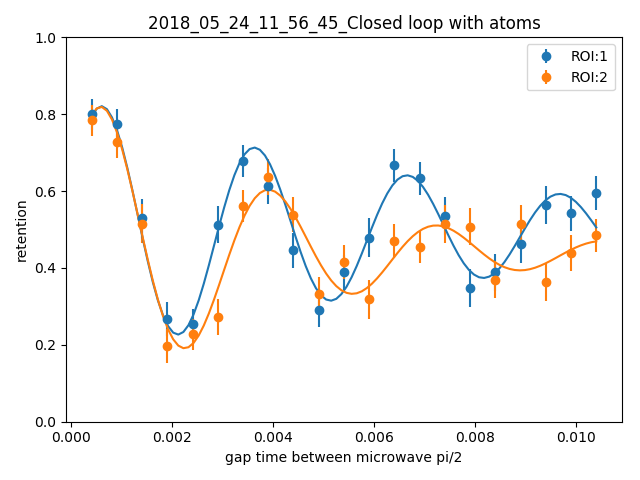

[0.017, 0.2874492064882902, 300, 1.5707963267948966, 0.51255079351170985]
tau 1  is  0.00756851584467  with 1 std of   0.00145752757048
amplitude 1  is  0.354251805184  with 1 std of   0.0357603999839
frequency 1  is  330.50424401  with 1 std of   4.3500324071
phase 1  is  0.268005757717  with 1 std of   0.118648200827
offset 1  is  0.494211849363  with 1 std of   0.00960903845518
[0.017, 0.32529692529692528, 300, 1.5707963267948966, 0.45931845931845933]
tau 2  is  0.00395495160289  with 1 std of   0.000783749298779
amplitude 2  is  0.442799021782  with 1 std of   0.058573704685
frequency 2  is  300.759439707  with 1 std of   9.1888211454
phase 2  is  0.344791812736  with 1 std of   0.174461250417
offset 2  is  0.440099393707  with 1 std of   0.0127985186917
2018_05_24_12_12_20_Closed loop with atoms
17


<IPython.core.display.Javascript object>


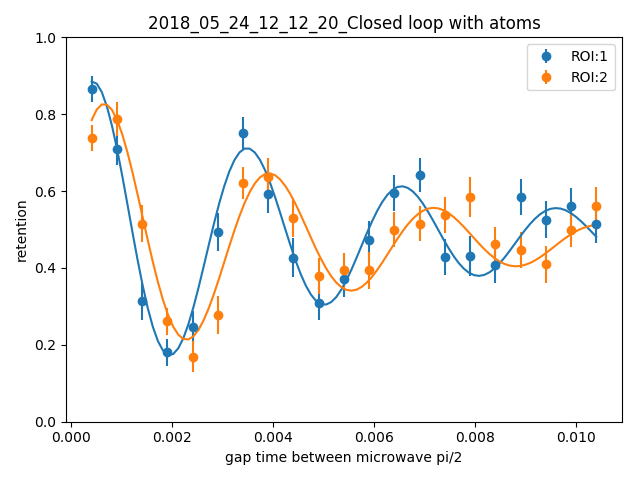

[0.017, 0.36861077133648845, 300, 1.5707963267948966, 0.49625409352837646]
tau 1  is  0.00548223502872  with 1 std of   0.00083796072791
amplitude 1  is  0.439321763061  with 1 std of   0.04034225505
frequency 1  is  326.67131778  with 1 std of   4.97168751859
phase 1  is  0.62278983609  with 1 std of   0.116535428822
offset 1  is  0.47984114415  with 1 std of   0.0100867958062
[0.017, 0.3012432012432012, 300, 1.5707963267948966, 0.48663558663558665]
tau 2  is  0.00468084529699  with 1 std of   0.00088558539146
amplitude 2  is  0.415547168129  with 1 std of   0.0513688715624
frequency 2  is  306.393143894  with 1 std of   7.24730661185
phase 2  is  0.212421932782  with 1 std of   0.151699617557
offset 2  is  0.467272970774  with 1 std of   0.0116925711926
2018_05_24_12_27_22_Closed loop with atoms
18


<IPython.core.display.Javascript object>


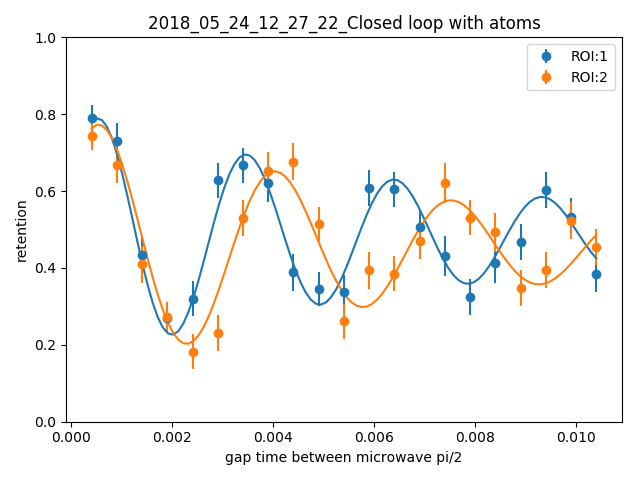

[0.017, 0.2938641338103069, 300, 1.5707963267948966, 0.49560955040021942]
tau 1  is  0.00803777585058  with 1 std of   0.0016792634579
amplitude 1  is  0.328411660309  with 1 std of   0.034617864775
frequency 1  is  341.087943005  with 1 std of   4.48061841609
phase 1  is  0.389449234721  with 1 std of   0.125200805348
offset 1  is  0.482157556737  with 1 std of   0.00953272002018
[0.017, 0.27808857808857812, 300, 1.5707963267948966, 0.46433566433566431]
tau 2  is  0.00728286014361  with 1 std of   0.00203314457972
amplitude 2  is  0.344845047212  with 1 std of   0.0504305566425
frequency 2  is  286.45616647  with 1 std of   6.63893675509
phase 2  is  0.530121460453  with 1 std of   0.180305114331
offset 2  is  0.453693357875  with 1 std of   0.0139001368988
2018_05_24_12_41_35_Closed loop with atoms
19


<IPython.core.display.Javascript object>


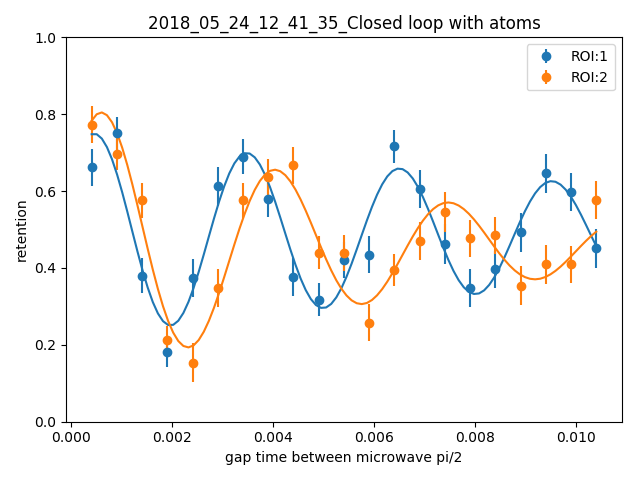

[0.017, 0.2504250565207003, 300, 1.5707963267948966, 0.4995749434792997]
tau 1  is  0.0142827545092  with 1 std of   0.00640292971914
amplitude 1  is  0.271186401341  with 1 std of   0.0411498094032
frequency 1  is  330.904757371  with 1 std of   5.1982288041
phase 1  is  0.599904290137  with 1 std of   0.173460861117
offset 1  is  0.486765968181  with 1 std of   0.0126840199763
[0.017, 0.30159840159840162, 300, 1.5707963267948966, 0.47112887112887109]
tau 2  is  0.00615118993311  with 1 std of   0.00134363973564
amplitude 2  is  0.384764076825  with 1 std of   0.0481094838306
frequency 2  is  290.929412143  with 1 std of   6.18332355336
phase 2  is  0.401562675624  with 1 std of   0.154523980743
offset 2  is  0.45656775183  with 1 std of   0.0124740068149
2018_05_24_12_56_48_Closed loop with atoms
20


<IPython.core.display.Javascript object>


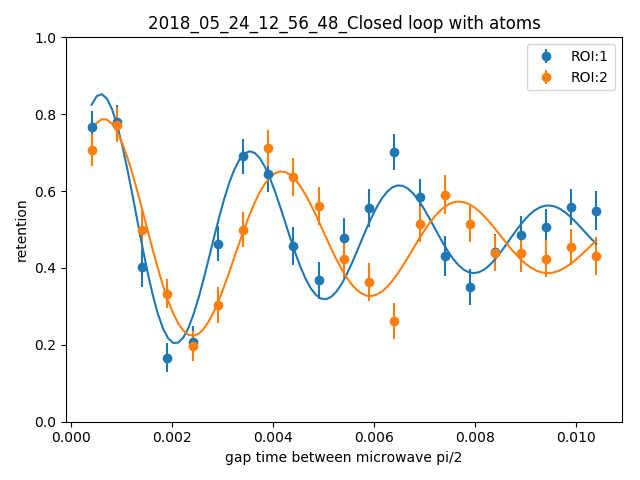

[0.017, 0.27530081144001195, 300, 1.5707963267948966, 0.50436020550914062]
tau 1  is  0.00566615768361  with 1 std of   0.00121460819091
amplitude 1  is  0.407510343719  with 1 std of   0.0523676402979
frequency 1  is  338.277236923  with 1 std of   6.49691164095
phase 1  is  0.251652098262  with 1 std of   0.154199368385
offset 1  is  0.486034748864  with 1 std of   0.0128492161871
[0.017, 0.29264069264069259, 300, 1.5707963267948966, 0.48008658008658012]
tau 2  is  0.00634595285099  with 1 std of   0.00144550632493
amplitude 2  is  0.356719076799  with 1 std of   0.0460193441623
frequency 2  is  284.341761929  with 1 std of   6.09749450685
phase 2  is  0.332951051402  with 1 std of   0.154907704485
offset 2  is  0.466805334118  with 1 std of   0.0118996444353
2018_05_24_13_09_08_Closed loop with atoms
21


<IPython.core.display.Javascript object>


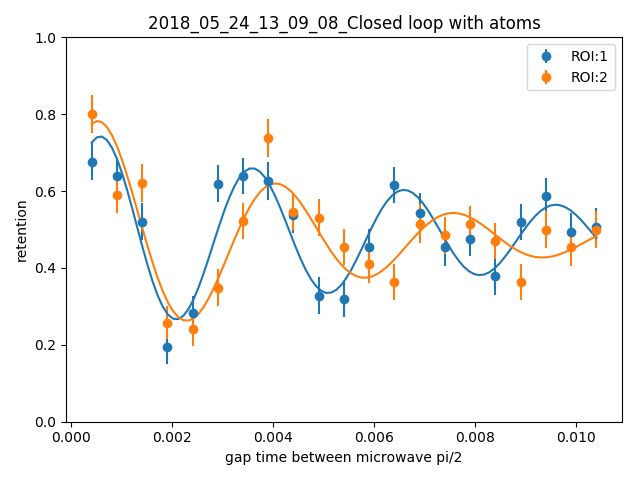

[0.017, 0.18121605409626795, 300, 1.5707963267948966, 0.49570702282680901]
tau 1  is  0.00787291900876  with 1 std of   0.0026265293783
amplitude 1  is  0.280953328796  with 1 std of   0.0478013866198
frequency 1  is  332.342228575  with 1 std of   7.20283776521
phase 1  is  0.318171887851  with 1 std of   0.2004830103
offset 1  is  0.481674008601  with 1 std of   0.0130242655643
[0.017, 0.31294261294261305, 300, 1.5707963267948966, 0.48705738705738699]
tau 2  is  0.00469757705647  with 1 std of   0.00141212272253
amplitude 2  is  0.346565057785  with 1 std of   0.0651845833451
frequency 2  is  283.813486379  with 1 std of   11.5228498623
phase 2  is  0.523301166706  with 1 std of   0.248869294858
offset 2  is  0.474426291024  with 1 std of   0.015719617916
2018_05_24_13_22_39_Closed loop with atoms
22


<IPython.core.display.Javascript object>


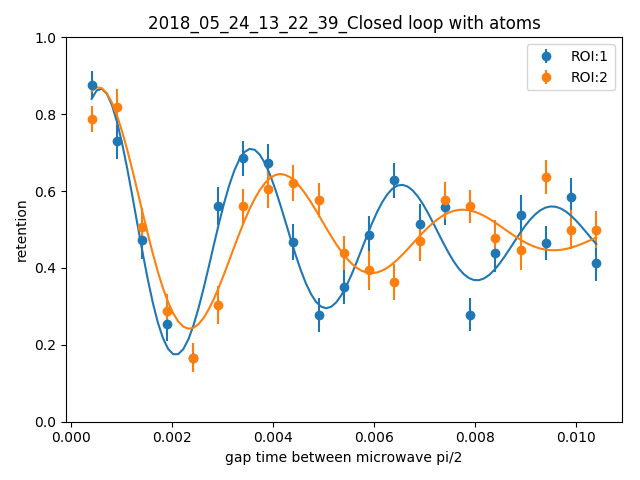

[0.017, 0.38079292721273533, 300, 1.5707963267948966, 0.49613014971034158]
tau 1  is  0.00581916010566  with 1 std of   0.0012361778182
amplitude 1  is  0.432562572691  with 1 std of   0.0543997357989
frequency 1  is  335.263444278  with 1 std of   6.28209646023
phase 1  is  0.27839147812  with 1 std of   0.151550823621
offset 1  is  0.476259157966  with 1 std of   0.0135241645665
[0.017, 0.31354201354201361, 300, 1.5707963267948966, 0.50463980463980462]
tau 2  is  0.00404923642875  with 1 std of   0.000902352641246
amplitude 2  is  0.441496171673  with 1 std of   0.0640931107708
frequency 2  is  277.04916271  with 1 std of   10.1280964477
phase 2  is  0.503407837244  with 1 std of   0.198335579678
offset 2  is  0.487242102424  with 1 std of   0.0145813012409
2018_06_04_17_42_01_Ramsey closed loop
23


<IPython.core.display.Javascript object>


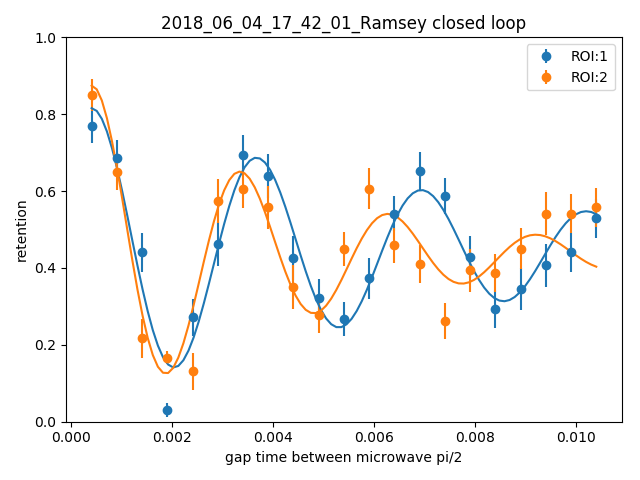

[0.017, 0.31053589858339642, 300, 1.5707963267948966, 0.45758004344558906]
tau 1  is  0.0077192846255  with 1 std of   0.00168198164029
amplitude 1  is  0.393525101269  with 1 std of   0.0453388354408
frequency 1  is  306.129544126  with 1 std of   5.40737475705
phase 1  is  0.735709073012  with 1 std of   0.145202651468
offset 1  is  0.442827798143  with 1 std of   0.0127455466352
[0.017, 0.40054938598037482, 300, 1.5707963267948966, 0.44945061401962516]
tau 2  is  0.0041367203997  with 1 std of   0.00106916748683
amplitude 2  is  0.488421941383  with 1 std of   0.082412653827
frequency 2  is  341.042440442  with 1 std of   11.51403711
phase 2  is  0.594245698128  with 1 std of   0.225148394
offset 2  is  0.434052760241  with 1 std of   0.0186653444728
2018_06_04_17_59_41_Ramsey closed loop
24


<IPython.core.display.Javascript object>


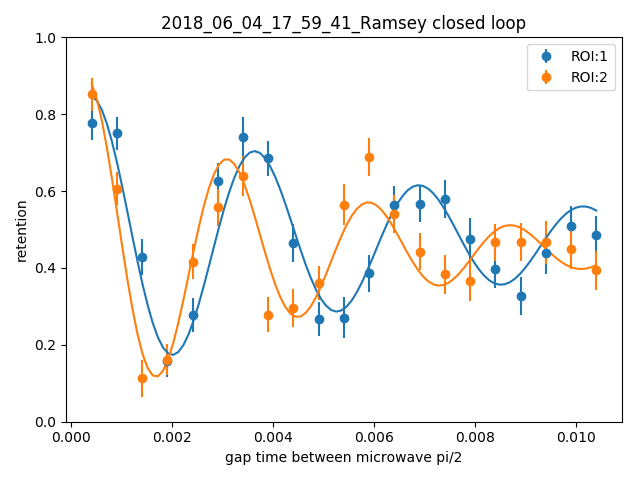

[0.017, 0.29161070966312896, 300, 1.5707963267948966, 0.48450869332194568]
tau 1  is  0.00681238465859  with 1 std of   0.00153701195112
amplitude 1  is  0.399090236131  with 1 std of   0.0506992917967
frequency 1  is  307.170391941  with 1 std of   6.3070970555
phase 1  is  0.77699575566  with 1 std of   0.160912271551
offset 1  is  0.470473564551  with 1 std of   0.013716109337
[0.017, 0.39954882358372573, 300, 1.5707963267948966, 0.45291019280971684]
tau 2  is  0.00438047343638  with 1 std of   0.000906495299893
amplitude 2  is  0.483792487714  with 1 std of   0.0662944653479
frequency 2  is  356.199070822  with 1 std of   8.56963191126
phase 2  is  0.862143384805  with 1 std of   0.170798617564
offset 2  is  0.445224712834  with 1 std of   0.0148401446518
2018_06_04_19_36_47_Ramsey closed loop
25


<IPython.core.display.Javascript object>


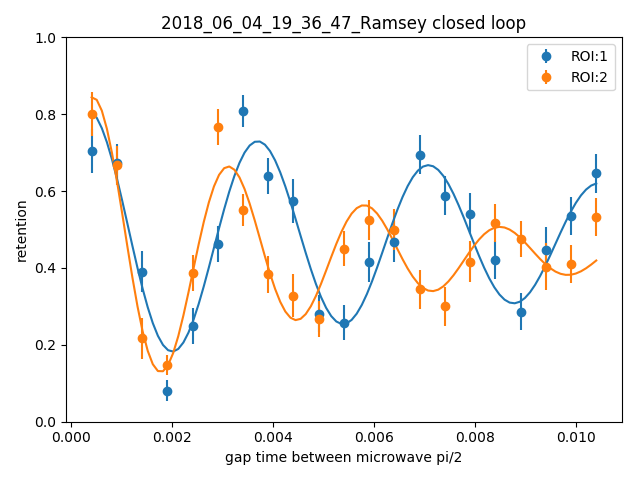

[0.017, 0.32553108299113903, 300, 1.5707963267948966, 0.4839927265326705]
tau 1  is  0.0120766401444  with 1 std of   0.00432907424233
amplitude 1  is  0.345831839208  with 1 std of   0.0496256363641
frequency 1  is  295.640565304  with 1 std of   5.50247634398
phase 1  is  0.954375788878  with 1 std of   0.169157636168
offset 1  is  0.475209885628  with 1 std of   0.0151546734686
[0.017, 0.35302393123651721, 300, 1.5707963267948966, 0.44697606876348284]
tau 2  is  0.00462877096859  with 1 std of   0.000936852766337
amplitude 2  is  0.450011862933  with 1 std of   0.0578533041443
frequency 2  is  371.826539701  with 1 std of   7.87274425172
phase 2  is  0.493925336284  with 1 std of   0.165274354139
offset 2  is  0.435355794348  with 1 std of   0.0136325585563


In [7]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.01, 0.40, 350 ,1.3, 0.5]
    fit_guesses2=[0.01, 0.25, 350 ,1.3, 0.45]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        fit_guesses = [0.017,Ampguess , 300 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
        plt.plot(xarray,yfit,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


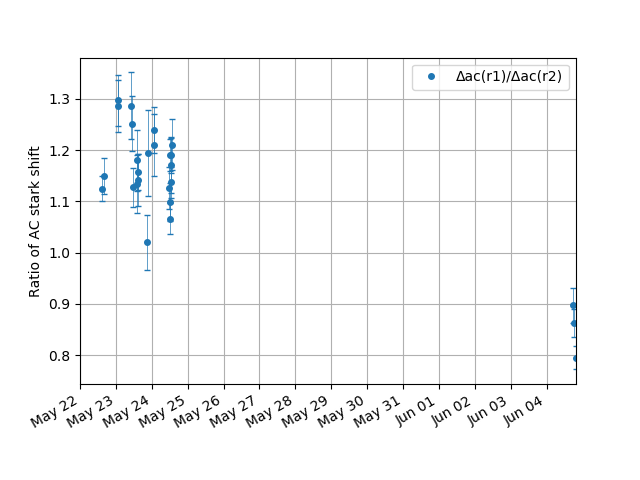

<IPython.core.display.Javascript object>


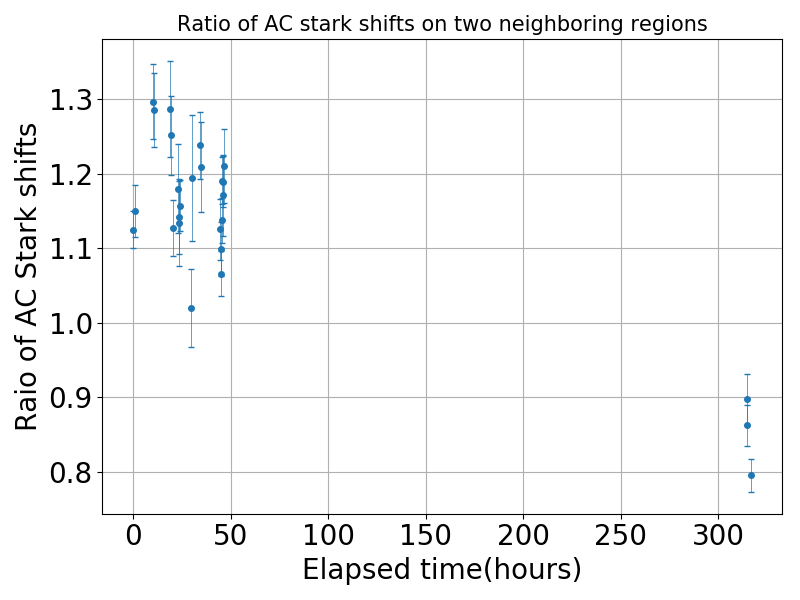

In [8]:
savefig=False
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
#df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,22),)
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


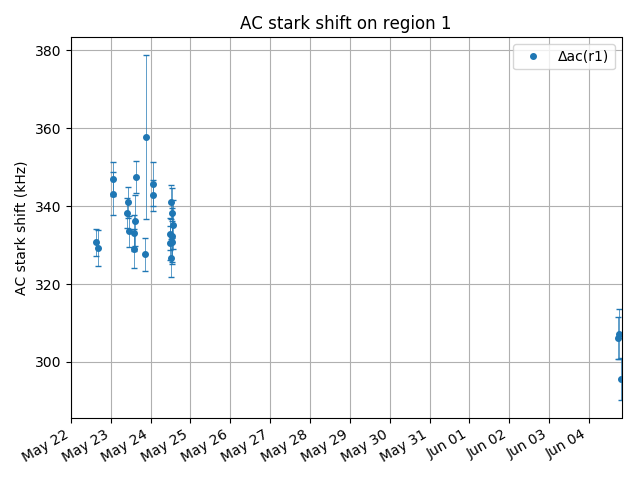

<IPython.core.display.Javascript object>


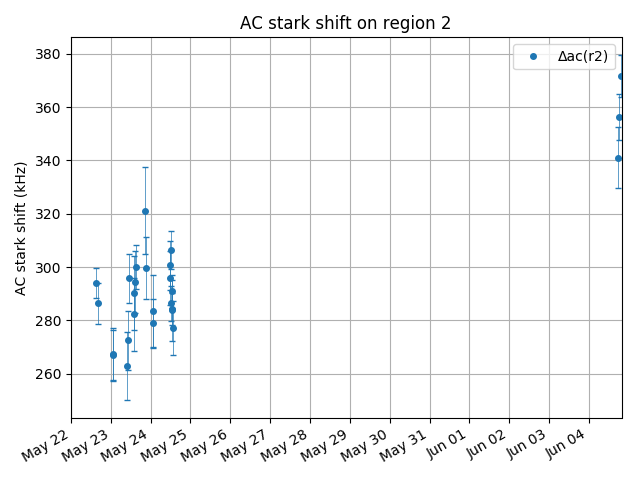

In [9]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
if savefig:
    plt.savefig('r1_ac_starkshift.pdf')

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,5,22))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()
ax2.set_ylabel('AC stark shift (kHz)')
ax2.set_title('AC stark shift on region 2')
plt.tight_layout()
if savefig:
    plt.savefig('r2_ac_starkshift.pdf')


In [12]:
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
plt.savefig('r1_ac_starkshift')
# peakshift_r1 = 825.0
# peakshift_r2 = 825.0
# wx_r1 = 8.2
# wx_r2= 8.2
peakshift=825
wx=8.1
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
# fig, ax = plt.subplots()
# plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
# plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
# plt.show()

# fig, ax = plt.subplots()
# xxx = np.arange(-.3, 0.3, 0.005)
# plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
# plt.show()


In [13]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
#for i in [1]:
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 26
doing 1-th fit.. out of 26
doing 2-th fit.. out of 26
doing 3-th fit.. out of 26
doing 4-th fit.. out of 26
doing 5-th fit.. out of 26
doing 6-th fit.. out of 26
doing 7-th fit.. out of 26
doing 8-th fit.. out of 26
doing 9-th fit.. out of 26
doing 10-th fit.. out of 26
doing 11-th fit.. out of 26
doing 12-th fit.. out of 26
doing 13-th fit.. out of 26
doing 14-th fit.. out of 26
doing 15-th fit.. out of 26
doing 16-th fit.. out of 26
doing 17-th fit.. out of 26
doing 18-th fit.. out of 26
doing 19-th fit.. out of 26
doing 20-th fit.. out of 26
doing 21-th fit.. out of 26
doing 22-th fit.. out of 26
doing 23-th fit.. out of 26
doing 24-th fit.. out of 26
doing 25-th fit.. out of 26


<IPython.core.display.Javascript object>


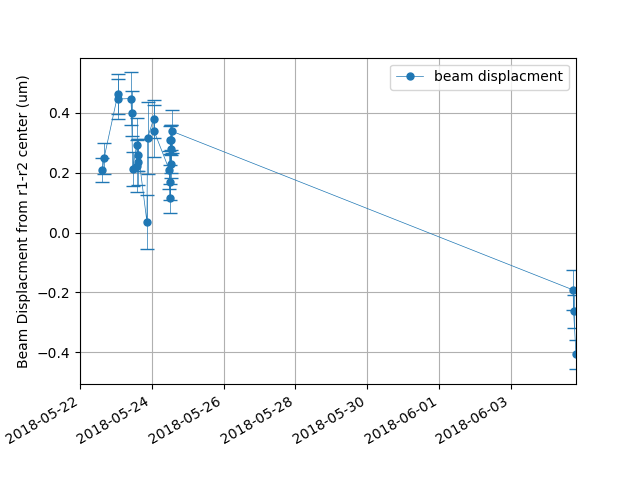

In [14]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.set_xlim(dt.datetime(2018,5,22))
ax.grid()

<IPython.core.display.Javascript object>


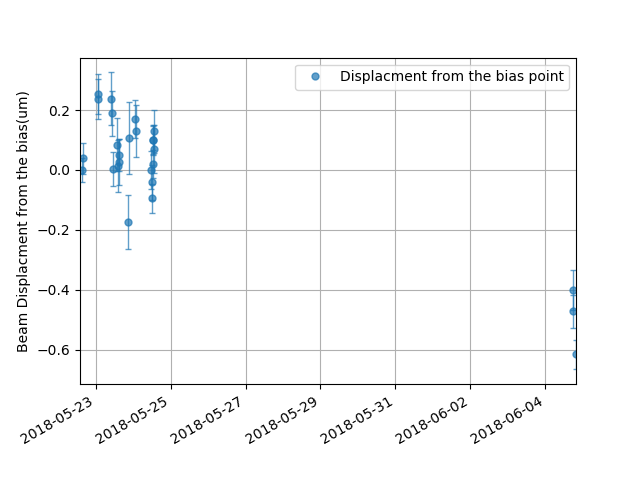

In [15]:
start_offset=np.mean(ratio_to_dist[0]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_xlim(dt.datetime(2018,5,22,14))
#ax.set_ylim(-1,1)
#days=md.DayLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))

ax.grid()

<IPython.core.display.Javascript object>


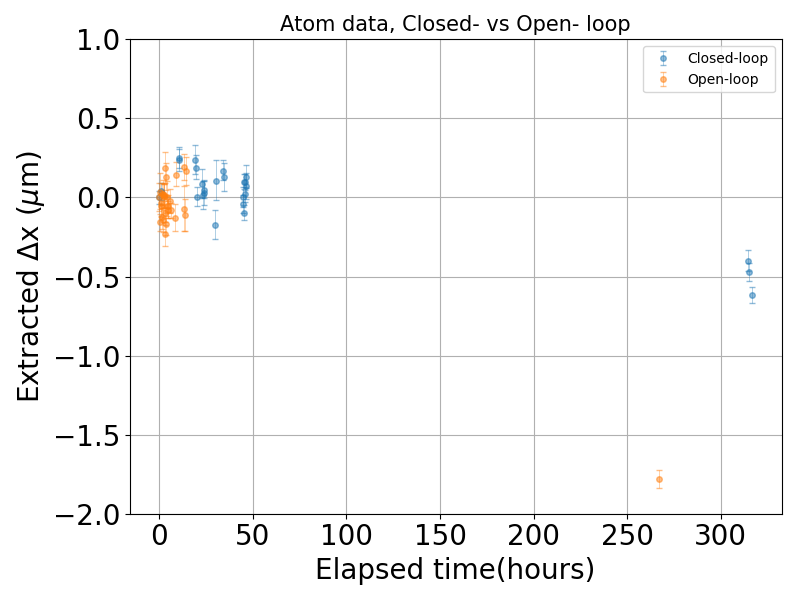

In [30]:
# with open-loop data
filename2='20180522_through_20180604_Extracted_OpenLoop'
timediff2=np.load(filename2+'_timediff'+'.npy')
displacement_frombias2=np.load(filename2+'_displacement_frombias'+'.npy')
dist_max_error2=np.load(filename2+'_dist_max_error'+'.npy')
dist_min_error2=np.load(filename2+'_dist_min_error'+'.npy')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=4,linestyle='None',label='Closed-loop')
ax.errorbar(timediff2,displacement_frombias2,yerr=[dist_max_error2,dist_min_error2],capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=4,linestyle='None',label='Open-loop')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$x ($\mu$m)',fontsize=20)
ax.set_title('Atom data, Closed- vs Open- loop',fontsize=15)
ax.set_ylim(-2,1)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend()
plt.tight_layout()
filename='20180522_through_20180604_Extracted_ClosedLoop'
plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [31]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=['2018_05_22_17_04_59_Closed loop without atoms',
         '2018_05_23_01_57_43_Closed loop without atoms',
         '2018_05_23_16_10_49_Closed loop with no atoms',
         '2018_05_23_18_43_54_Closed loop with no atoms',
         '2018_05_23_21_21_33_Closed loop with no atoms',
         '2018_05_23_22_59_47_Closed loop with no atoms',
        '2018_05_23_23_55_40_Closed loop with atoms',
         '2018_05_24_00_37_26_Closed loop with atoms',
        '2018_05_24_01_00_19_Closed loop with atoms',
         #'2018_05_24_01_10_08_Closed loop, scanning microwave freq',
         '2018_05_24_02_16_42_Closed loop with atoms, FORT lowered',
         '2018_05_24_02_29_20_Closed loop with no atoms' 
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_17_11_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_36_47_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_09_57_07_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_10_33_33_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :

In [12]:
dates

True

<IPython.core.display.Javascript object>


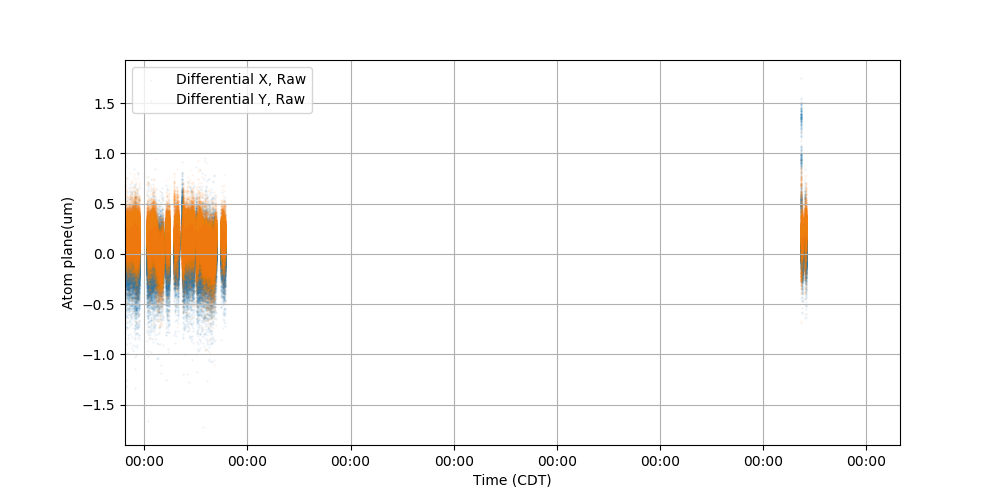

In [32]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],)
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

In [45]:
flattendedtimestamps[0]

1527019230.6429999

<IPython.core.display.Javascript object>


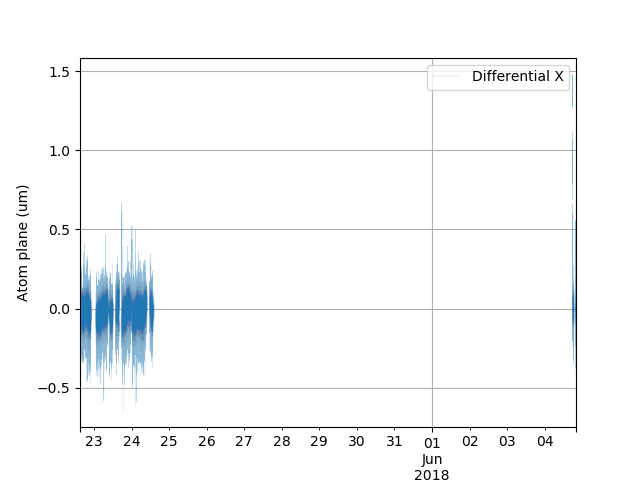

<IPython.core.display.Javascript object>


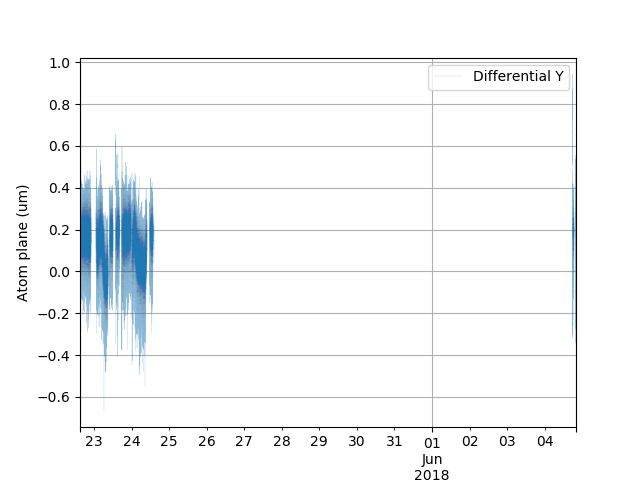

<IPython.core.display.Javascript object>


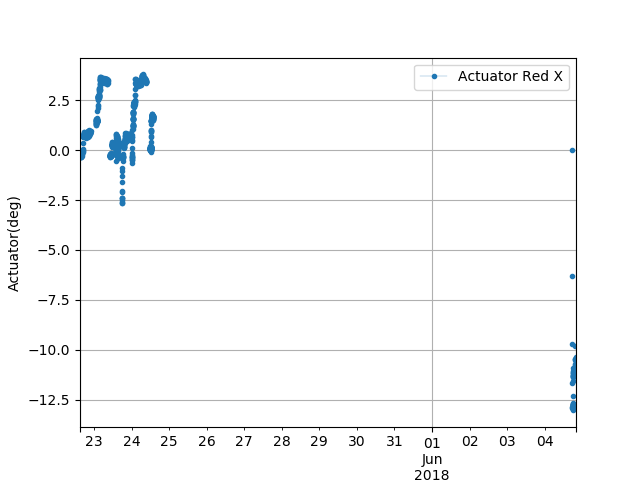

<IPython.core.display.Javascript object>


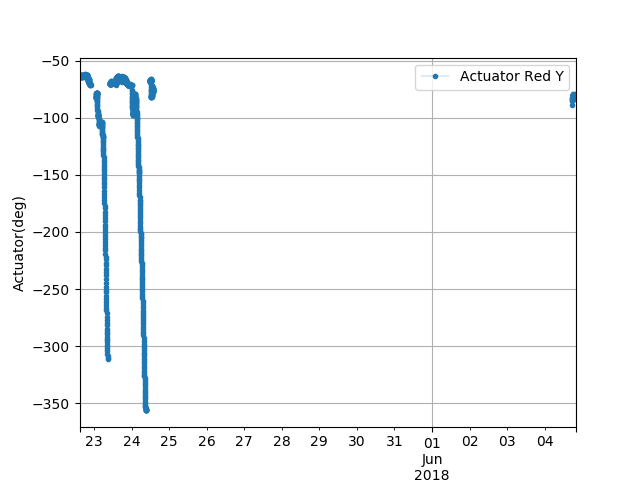

In [33]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)


## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Differential Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

ax=data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

ax=data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


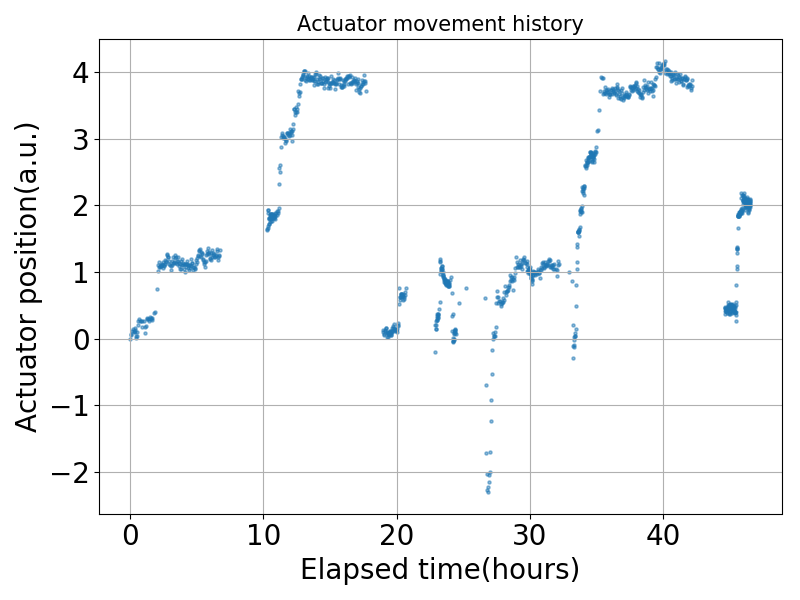

75
253
945
948


<IPython.core.display.Javascript object>


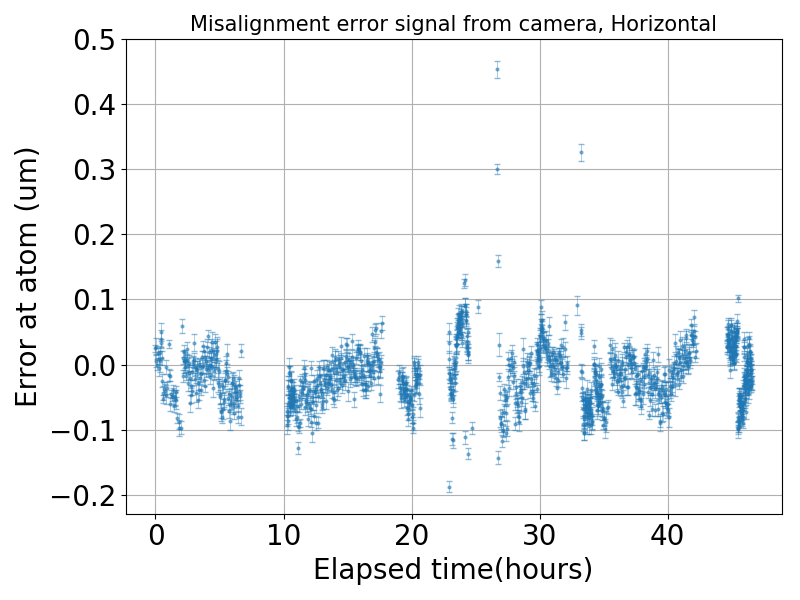

In [46]:
## Actuator Plot
savefig=True
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


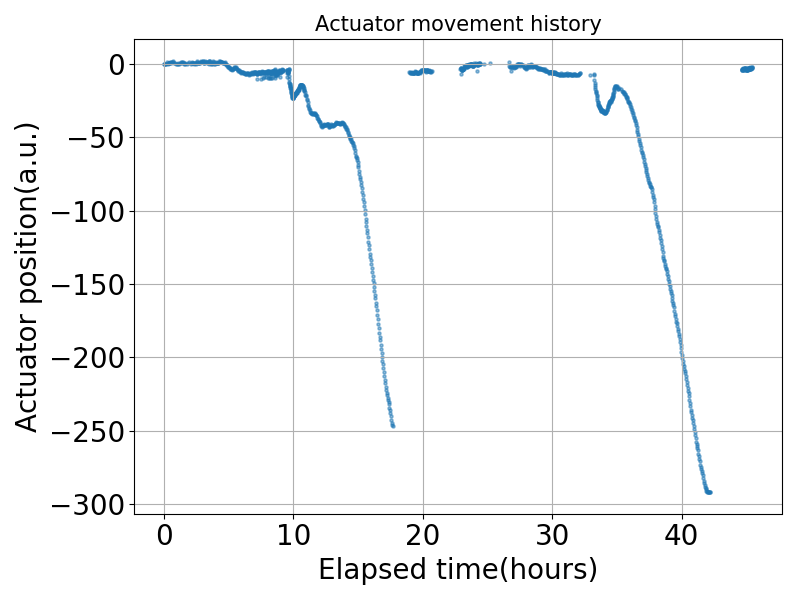

264
442
1029
1032


<IPython.core.display.Javascript object>


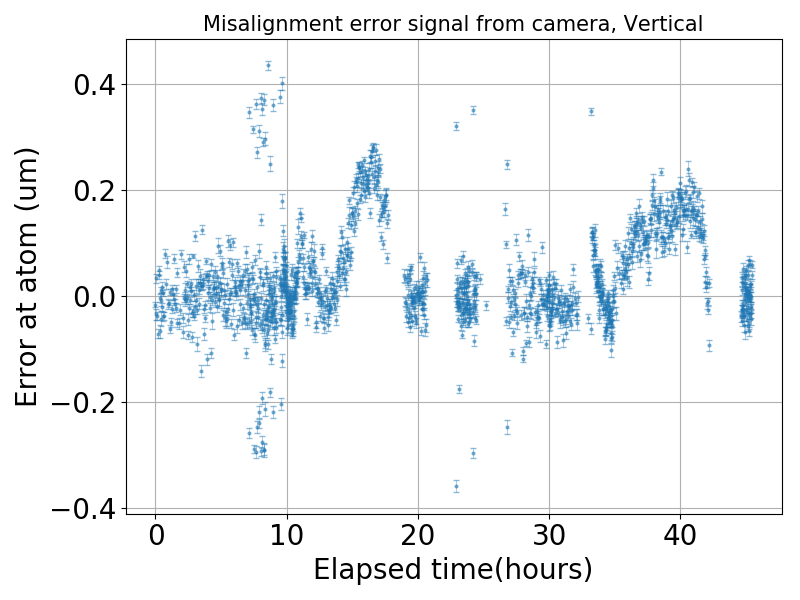

In [109]:
## Actuator Plot
savefig=True
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


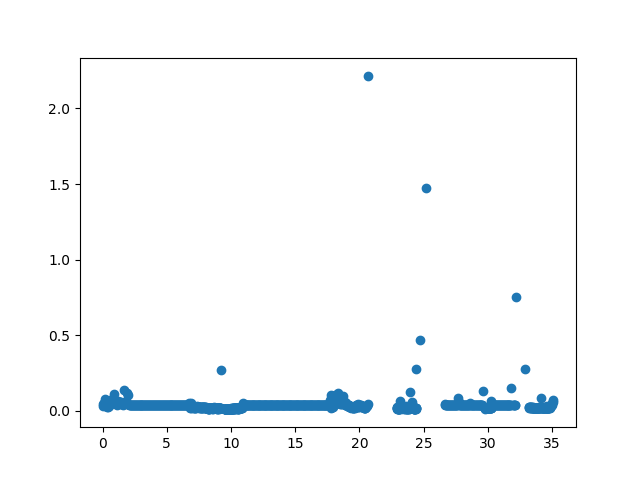

T=20.6829047222, duration of :2.21701666666


In [18]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


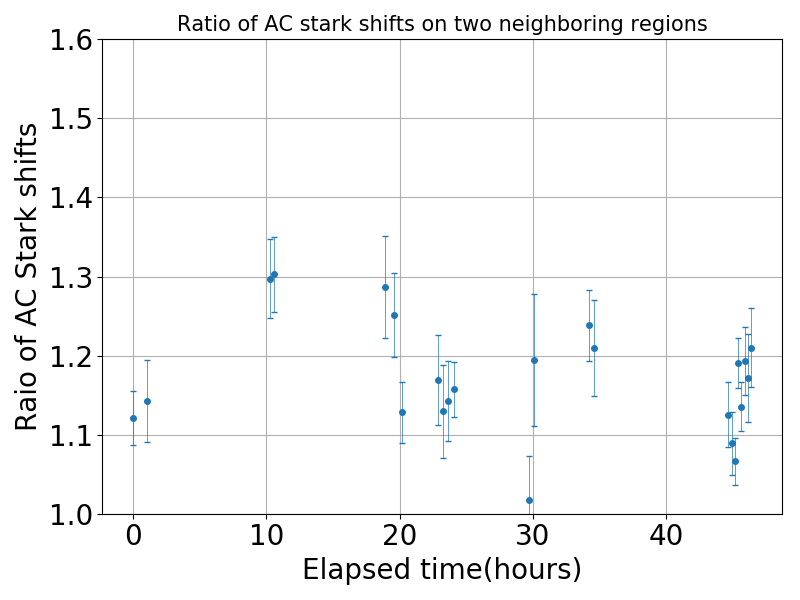

In [47]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Insert room temperature history

<IPython.core.display.Javascript object>


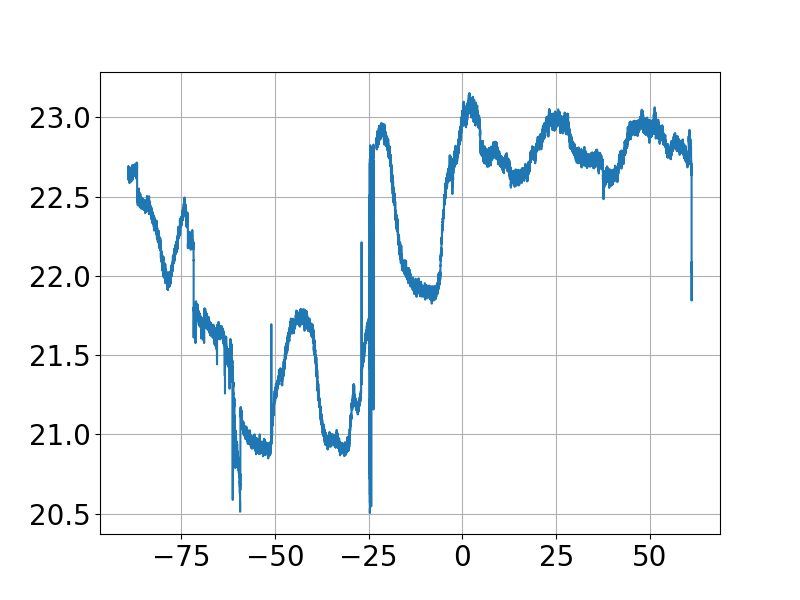

22.6327109524


In [48]:
from numpy import genfromtxt
my_data=genfromtxt('Rb_labtemperature.csv',delimiter=',')
temperatures_in_C=np.array(my_data[:,1])
timestamps=np.array(my_data[:,0])/2**32
offset=temperatures_in_C[0]#np.mean(temperatures_in_C)
experiment_start_time=flattendedtimestamps[0]
# Cutting weird data off (due to bad eletric connection.. etc)
temp_threshold_upper=25
temp_threshold_lower=20.5

indices1 = temperatures_in_C > temp_threshold_upper
indices2 = temperatures_in_C < temp_threshold_lower
final_indices=np.logical_or(indices1,indices2)
temperatures_in_C[final_indices]=np.NaN
fig, ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot((timestamps-experiment_start_time)/3600,temperatures_in_C)
ax.grid()
#ax.set_ylim(18,23)
ax.tick_params(labelsize=20)

# for i in range(0,len(dead_T)):
#      ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.4,0.4,alpha=0.1,color='r')

print temperatures_in_C[0]

In [48]:
my_data

array([[  6.55712007e+18,   2.26327110e+01,   3.34742380e+03],
       [  6.55712008e+18,   2.26325596e+01,   3.34744660e+03],
       [  6.55712016e+18,   2.26359802e+01,   3.34693150e+03],
       ..., 
       [  6.55735520e+18,   2.24339886e+01,   3.37750250e+03],
       [  6.55735521e+18,   2.24349951e+01,   3.37734940e+03],
       [  6.55735522e+18,   2.24367175e+01,   3.37708740e+03]])

<IPython.core.display.Javascript object>


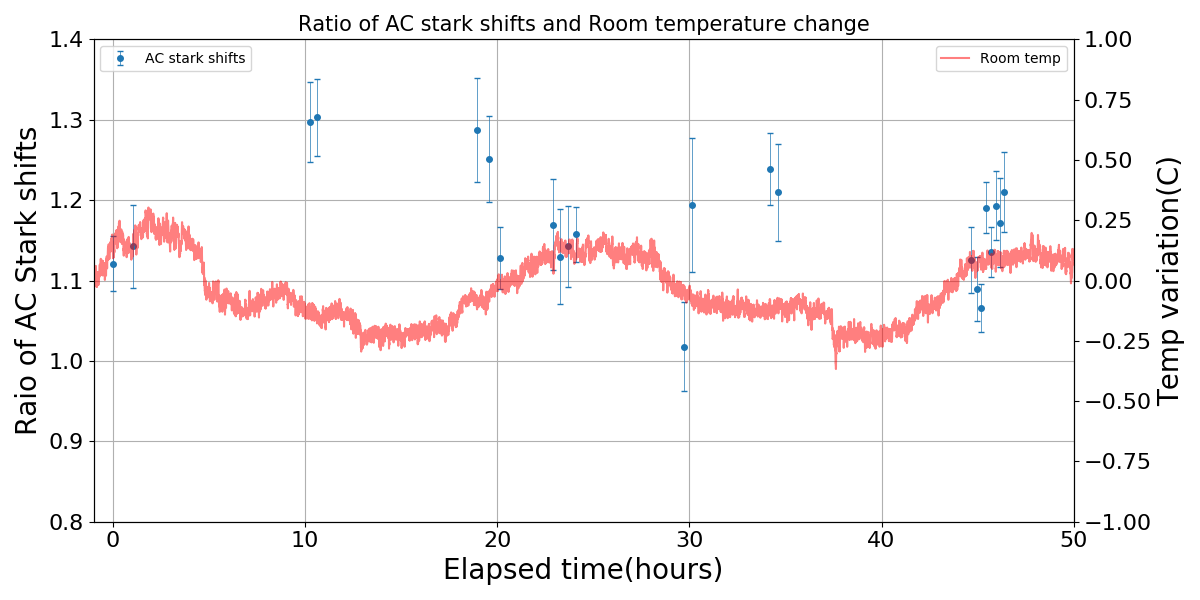

In [53]:
# Together!!
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='AC stark shifts')
ax2=ax.twinx()
ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax2.set_ylabel('Temp variation(C)',fontsize=20)
ax.set_title('Ratio of AC stark shifts and Room temperature change',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='gray')

ax.set_xlim(-1,50)
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylim(-1,1)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# filename='20180422_AC_starkshifts and temperature'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')


<IPython.core.display.Javascript object>


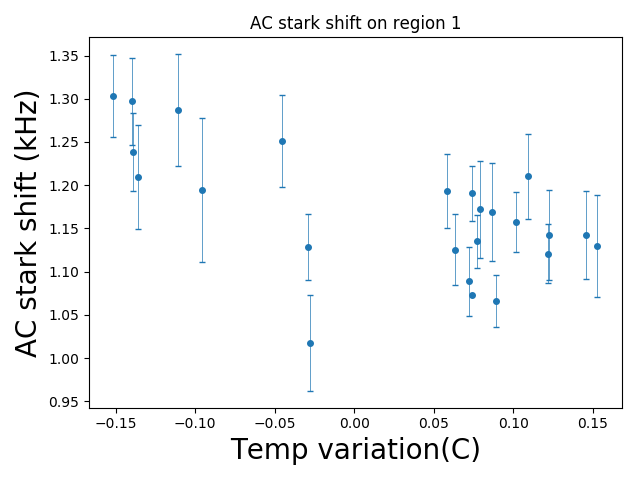

In [20]:
offset=22.85
interpolated_temperature=np.interp(timediff,(timestamps-experiment_start_time)/3600,temperatures_in_C-offset)
fig, ax=plt.subplots()
#ax.scatter(interpolated_temperature,ratio_data)
ax.errorbar(interpolated_temperature,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
#ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


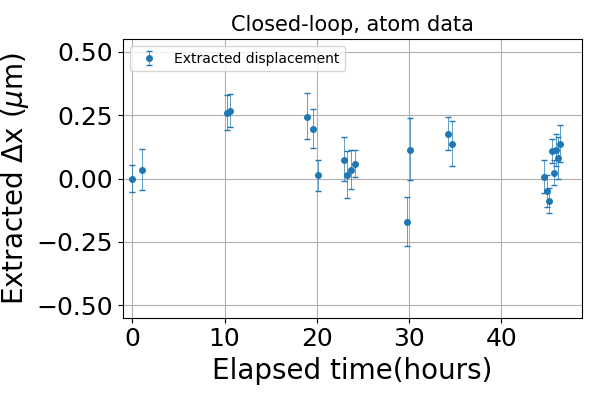

In [72]:
offset=22.85
display_ax2=False
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$x ($\mu$m)',fontsize=20)
ax.tick_params(labelsize=18)
scaler=1
ax.set_ylim(scaler*-0.55,scaler*0.55)

if display_ax2:
    ax2=ax.twinx()
    ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.3,label='System temperature')
    ax2.set_ylim(scaler*-0.3,scaler*0.3)
    ax2.tick_params(labelsize=16)
    ax2.set_ylabel(r'Temp variation $\Delta$T (C)',fontsize=20)
    ax2.legend(loc='upper right')
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Closed-loop, atom data',fontsize=15)
plt.tight_layout()
ax.set_xlim(-1,)
filename='20180522_Extracted_horizontal_misalignment_and_Temperature'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


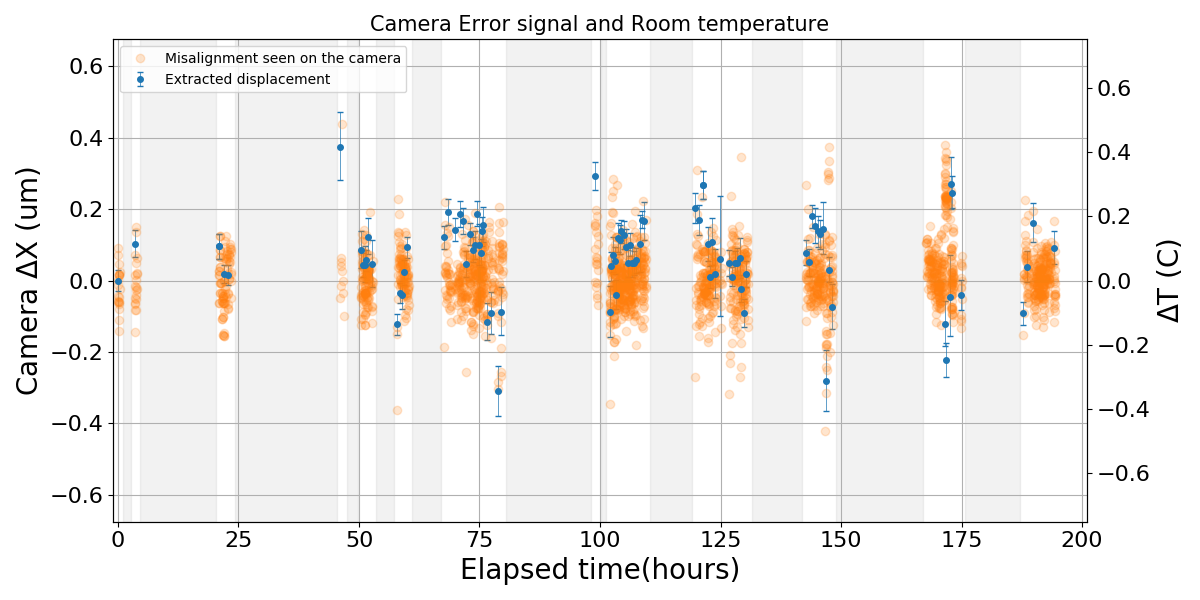

In [209]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Misalignment seen on the camera',marker='o',linestyle='none',alpha=0.2)
ax2=ax.twinx()
#ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_Camera_and_Atom_comparison'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [ ]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Extracted displacement',marker='o',linestyle='none',alpha=0.2)
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_camera_horizontal_misalignment_and_Temperature'
savefig=False
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


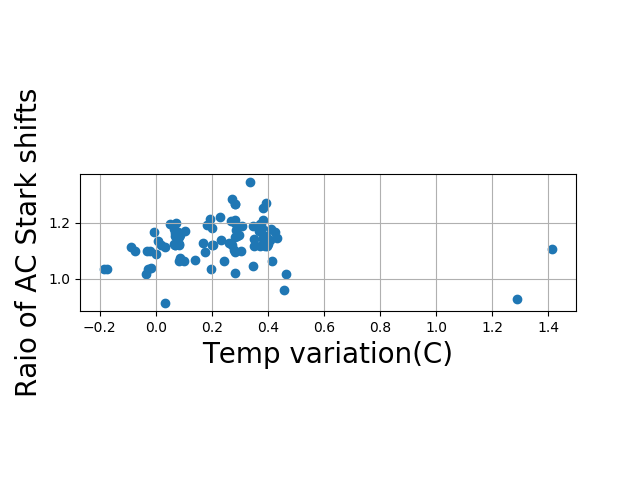

In [51]:
interpolated_temperature=np.interp(timediff,timestamps,temperatures_in_C-offset)
fig, ax=plt.subplots()
ax.scatter(interpolated_temperature,ratio_data)
ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


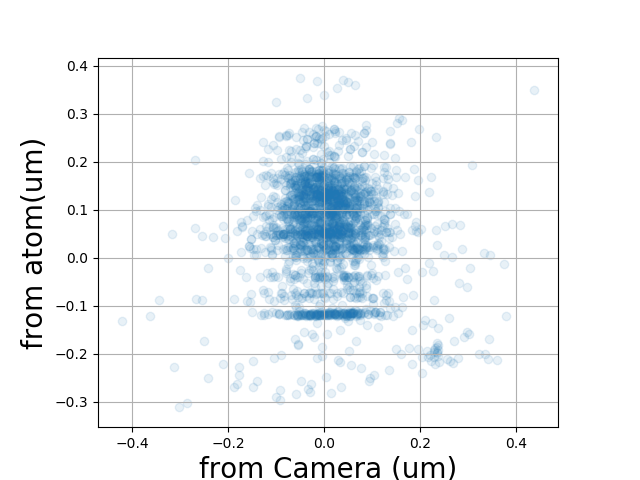

In [172]:
# Camera Error signal vs Atom signal
# elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x
time_offset=0
#interpolated_error_x=np.interp(timediff+time_offset,elapsed_time_in_hours,camera_error_x)
interpolated_atom_x=np.interp(elapsed_time_in_hours+time_offset,timediff,displacement_frombias)
fig, ax=plt.subplots()
#ax.hexbin(camera_error_x,interpolated_atom_x,gridsize=40)
#ax.scatter(camera_error_x,interpolated_atom_x,alpha=0.1)
ax.set_aspect('equal')
ax.set_xlabel('from Camera (um)',fontsize=20)
ax.set_ylabel('from atom(um)',fontsize=20)
ax.grid()
ax.set_aspect('equal')

In [154]:
np.size(elapsed_time_in_hours)

2195

In [126]:
timediff

array([   0.        ,    3.48471694,   20.94659722,   20.94659722,
         22.02374889,   22.83502472,   46.14175194,   50.43195417,
         50.84260028,   51.18150556,   51.51876861,   51.89722056,
         52.62958306,   57.91884361,   58.47059389,   58.96669083,
         59.43727583,   59.87217111,   67.66185556,   68.4693075 ,
         69.94930583,   70.91257583,   71.56578667,   72.24758389,
         72.94265833,   73.585415  ,   73.98553194,   74.47450361,
         74.86974083,   75.21645028,   75.52191667,   75.8017675 ,
         76.52271417,   77.30667389,   78.7948975 ,   79.47338528,
         98.91573222,  102.01844167,  102.33729306,  102.68075111,
        103.04679111,  103.39736528,  103.73350472,  104.14270861,
        104.44181667,  104.89870722,  105.32815   ,  105.78663028,
        106.17394333,  106.56550694,  106.95965389,  107.38826667,
        108.2555825 ,  108.67492139,  109.06880278,  119.80086333,
        120.55649056,  121.37411861,  121.37411861,  122.35684

# Allan deviation

In [35]:
from IPython.display import display, clear_output
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,50)+range(10003,100003,50)+range(100004,1000004,50)#+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    
try:
    np.save('20180525_closedloop_taulist',tau_list)
    np.save('20180525_closedloop_X',np.sqrt(0.5*np.array(var_list['Differential X'])))
    np.save('20180525_closedloop_Y',np.sqrt(0.5*np.array(var_list['Differential Y'])))
except:
    pass

'Tau: 999954'

<IPython.core.display.Javascript object>


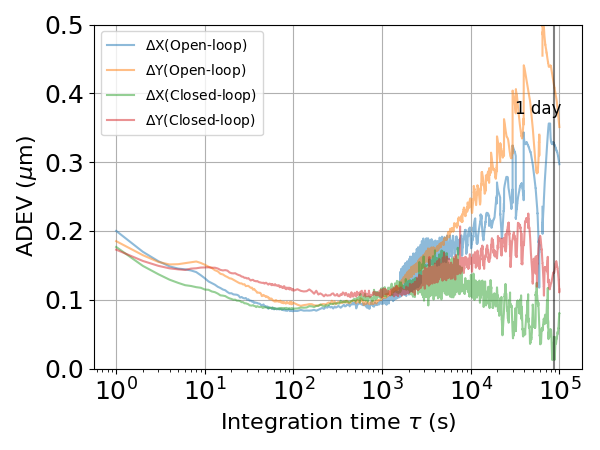

In [175]:
tau_list=np.load('20180525_openloop_taulist.npy')
Xlist=np.load('20180525_openloop_X.npy')
Ylist=np.load('20180525_openloop_Y.npy')

tau_list2=np.load('20180525_closedloop_taulist.npy')
Xlist2=np.load('20180525_closedloop_X.npy')
Ylist2=np.load('20180525_closedloop_Y.npy')


savefig=True
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
ax.semilogx(tau_list, Xlist,label=r'$\Delta$X(Open-loop)',alpha=0.5)
ax.semilogx(tau_list, Ylist,label=r'$\Delta$Y(Open-loop)',alpha=0.5)
ax.semilogx(tau_list2, Xlist2,label=r'$\Delta$X(Closed-loop)',alpha=0.5)
ax.semilogx(tau_list2, Ylist2,label=r'$\Delta$Y(Closed-loop)',alpha=0.5)
ax.tick_params(labelsize=18)
ax.legend()
plt.axvline(x=86400,color='black',alpha=0.5)
#ax.set_xlim(1,)
#ax.set_title('Allan Deviation (Open-loop vs Closed-loop)',size=)
ax.set_xlabel(r'Integration time $\tau$ (s)',size=16)
ax.set_ylabel(r'ADEV ($\mu$m)',size=16)
#ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**4.5,0.37,'1 day',size=12)
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_comparison'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
